In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import time
import gc
from scipy.stats import zscore
from scipy.signal import detrend
import copy
import sys
from scipy.integrate import simpson as simps
from nice.algorithms.connectivity import epochs_compute_wsmi
import mne
import warnings
warnings.filterwarnings("ignore")

# def preprocess(data):
#     data = detrend(data, axis=0)
#     epsilon = 1e-9
#     data = (data - np.mean(data, axis=0)) / (np.std(data, axis=0) + epsilon)
    
#     return data

    
def preprocess(data):
    stds = np.std(data[:, :], axis=0)
    non_constant_cols = stds > 1e-6
    if len(non_constant_cols) != 0:
        print('non constant column at ', np.where(non_constant_cols == False))
              
   
    constant_cols = stds < 1e-6

    z = np.zeros_like(data[:, :])
    z[:, non_constant_cols] = zscore(data[:, non_constant_cols], axis=0)
    z[:, constant_cols] = np.mean(data[:, constant_cols], axis = 0)

    #unsure what to replace lost values with, for now replacing with 0

    if np.isnan(z).any():
        raise ValueError("Data contains NaN values after normalization.")

    return z


file_numbers = [1, 2, 4, 8, 14, 15, 20, 23]

smi_means = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}
smi_stdevs = {f'dataset_{file_number}': {'left_attleft': [], 'right_attleft': [], 'left_attright': [], 'right_attright': []} for file_number in file_numbers}

total_time = time.time()
for file_number in  file_numbers:
    file_total = time.time()
    file_path = f'C:/Users/joshu/PartIIIProject/RSNNdale_attention_{file_number}_attention_test'
    load_data_start_time = time.time()
    data = pickle.load(open(file_path, 'rb'))
    elapsed_time = time.time() - load_data_start_time
    print(f"Dataset {file_number} loaded in {elapsed_time:.2f} seconds")

    attention_labels = data['label_attend'][0]
    label_left = data['label_left'][0]
    label_right = data['label_right'][0]
    attend_01 = data['attend'][0]
    omitted = data["omit"][0]
    relevant = np.where(omitted == 0)[0]

    # Extract LFP signals
    left_input_LFP = preprocess(data['LFP'][0][0][relevant])
    right_input_LFP = preprocess(data['LFP'][0][1][relevant])
    attention_LFP = preprocess(data['LFP_rec'][0][2][relevant])


    left_indices_agg = np.where((omitted ==0) & (attend_01 == 0))[0]  #indices of agg where left
    _, left_indices, _ = np.intersect1d(relevant, left_indices_agg, return_indices=True)   #indices for relevant processed data where attention left
    right_indices_agg = np.where((omitted ==0) & (attend_01 == 1))[0]
    _, right_indices, _ = np.intersect1d(relevant, right_indices_agg, return_indices=True)
    
                
    #print(f' found data for left {class_left}, right {class_right}')
    left_input_LFP_attleft = left_input_LFP[left_indices, 100:350]
    right_input_LFP_attleft = right_input_LFP[left_indices, 100:350]
    attention_LFP_attleft = attention_LFP[left_indices, 100:350]

    left_input_LFP_attright = left_input_LFP[right_indices, 100:350]
    right_input_LFP_attright = right_input_LFP[right_indices, 100:350]
    attention_LFP_attright = attention_LFP[right_indices, 100:350]

    #------------------------------formatting for smi calculation----------------------------------
    n_times = left_input_LFP_attleft.shape[1] ##=250
    print("n_samples", n_times)

    dt = 0.002
    sfreq = 1 / dt

    ch_names = ['left_input', 'right_input', 'attention_layer']
    ch_types = ['eeg', 'eeg', 'eeg']
    info = mne.create_info(ch_names=ch_names, sfreq=sfreq, ch_types=ch_types)


    #reshaping data for attention left
    raw_data_left = np.concatenate([
        left_input_LFP_attleft, 
        right_input_LFP_attleft, 
        attention_LFP_attleft 
    ], axis=0)  # Concatenate along time axis

    print("raw_data_left shape =", raw_data_left.shape)  
    # Reshape into (n_channels, n_samples)
    raw_data_left = raw_data_left.reshape(3, -1)  
    print('raw data left reshaped =', raw_data_left.shape) 
    raw_left = mne.io.RawArray(raw_data_left, info)
    print("raw_data_left =", raw_left)
    

    #reshaping date for attention right 
    raw_data_right = np.concatenate([
        left_input_LFP_attright,
        right_input_LFP_attright,
        attention_LFP_attright 
    ], axis=0)

    raw_data_right = raw_data_right.reshape(3, -1)
    raw_right = mne.io.RawArray(raw_data_right, info)


    #defininf event objects, arrays like [0,0,1], [250, 0, 1], [750, 0, 1] etc
    events_left = np.array([[i * n_times, 0, 1] for i in range(len(left_input_LFP_attleft))])
    events_right = np.array([[i * n_times, 0, 1] for i in range(len(left_input_LFP_attright))])

    
    print("events_left", events_left[:4])

    epochs_left = mne.Epochs(raw_left, events_left, event_id={'Trial': 1}, tmin=0, tmax =  0.498,  baseline=None, preload=True)
    epochs_right = mne.Epochs(raw_right, events_right, event_id={'Trial': 1}, tmin=0, tmax = 0.498, baseline=None, preload=True)
    print('----------------', (n_times - 1)/ sfreq)

    print("epochs_left", epochs_left)
    #epochs_left.plot(n_epochs=5, n_channels=3, scalings = 'auto', title="Attention Left")
    #plt.show()

    #-----------computing SMI for each τ for each condition--------------------------------
    kernel = 3
    taus = [8, 16, 32, 64]  # in ms
    smi_results = {'left': {}, 'right': {}}

    for tau in taus:
        tau_samples = int(tau / (1000 / sfreq))
        print(f"tau_samples for {tau}: {tau_samples}")
        
        _, smi_left, _, _ = epochs_compute_wsmi(
            epochs_left, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
        )
        smi_results['left'][tau] = smi_left
        #this containts the data for smi at a given tau given attending left. 

        _, smi_right, _, _ = epochs_compute_wsmi(
            epochs_right, kernel=kernel, tau=tau_samples, backend='python', method_params={'bypass_csd': True}
        )
        smi_results['right'][tau] = smi_right

    for tau in taus:
        smi_means[f'dataset_{file_number}']['left_attleft'].append(np.mean(smi_results['left'][tau][0, 2, :]))
        smi_means[f'dataset_{file_number}']['right_attleft'].append(np.mean(smi_results['left'][tau][1, 2, :]))
        smi_means[f'dataset_{file_number}']['left_attright'].append(np.mean(smi_results['right'][tau][0, 2, :]))
        smi_means[f'dataset_{file_number}']['right_attright'].append(np.mean(smi_results['right'][tau][1, 2, :]))

        smi_stdevs[f'dataset_{file_number}']['left_attleft'].append(np.std(smi_results['left'][tau][0, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['right_attleft'].append(np.std(smi_results['left'][tau][1, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['left_attright'].append(np.std(smi_results['right'][tau][0, 2, :], ddof = 1))
        smi_stdevs[f'dataset_{file_number}']['right_attright'].append(np.std(smi_results['right'][tau][1, 2, :], ddof = 1))

  
    del left_input_LFP_attleft, right_input_LFP_attleft, attention_LFP_attleft, left_input_LFP_attright, right_input_LFP_attright, attention_LFP_attright
    gc.collect()
    del(data)
    gc.collect()
    print(f'Dataset {file_number} complete in', time.time() - file_total)

print('total time elapsed =', time.time() - total_time)


c:\Users\joshu\nice\.venv\Lib\site-packages\mne\externals\tempita\__init__.py:35: DeprecationWarning: 'cgi' is deprecated and slated for removal in Python 3.13
  import cgi


Dataset 1 loaded in 13.70 seconds
non constant column at  (array([0]),)
non constant column at  (array([0]),)
non constant column at  (array([0, 1, 2, 3, 4, 5, 6, 7]),)
n_samples 250
raw_data_left shape = (1485, 250)
raw data left reshaped = (3, 123750)
Creating RawArray with float64 data, n_channels=3, n_times=123750
    Range : 0 ... 123749 =      0.000 ...   247.498 secs
Ready.
raw_data_left = <RawArray | 3 x 123750 (247.5 s), ~2.8 MB, data loaded>
Creating RawArray with float64 data, n_channels=3, n_times=140500
    Range : 0 ... 140499 =      0.000 ...   280.998 secs
Ready.
events_left [[  0   0   1]
 [250   0   1]
 [500   0   1]
 [750   0   1]]
Not setting metadata
Not setting metadata
495 matching events found
No baseline correction applied
0 projection items activated
Loading data for 495 events and 250 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
562 matching events found
No baseline correction applied
0 projection items activated
Loa

[np.float64(0.0669814550363727), np.float64(0.0695209332318761), np.float64(0.06743360667798526), np.float64(0.06262515834867742), np.float64(0.07039263593229093), np.float64(0.07019073935585113), np.float64(0.06509902241621719), np.float64(0.06380752186031222), np.float64(0.06396405799608114), np.float64(0.06483206121212168), np.float64(0.05767141268984663), np.float64(0.05889970400676224), np.float64(0.0628626461397945), np.float64(0.06321218043958143), np.float64(0.0697253766297554), np.float64(0.06894233781298083)]
[np.float64(0.10372762848982739), np.float64(0.10585579348073744), np.float64(0.106514149208352), np.float64(0.0987292036941533), np.float64(0.11279483152660563), np.float64(0.1091827404315476), np.float64(0.0990798913765788), np.float64(0.09856333944430812), np.float64(0.0999339680008005), np.float64(0.09992375568708611), np.float64(0.08768864793375873), np.float64(0.09010783272718723), np.float64(0.09351284706193623), np.float64(0.09799815436195156), np.float64(0.10716

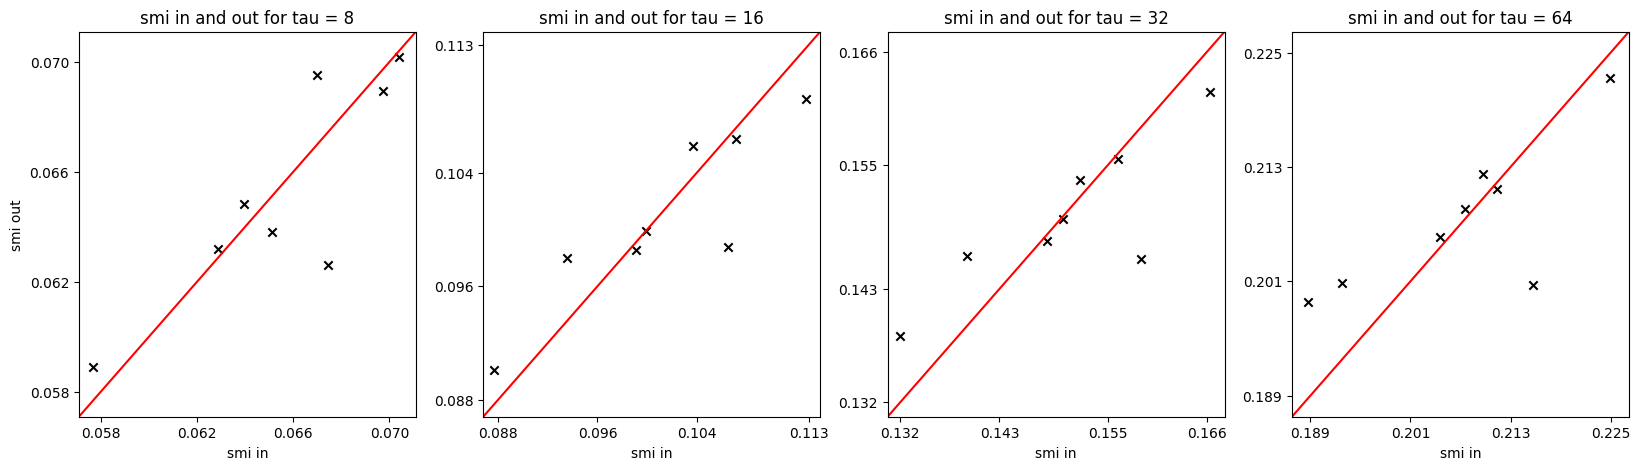

{'left': {8: array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.10754029, 0.11380803, 0.05930029, ..., 0.10128549,
         0.07015552, 0.13286285],
        [0.04223033, 0.05339875, 0.09013092, ..., 0.04495226,
         0.09759317, 0.06280697]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.06492317, 0.08638304, 0.07465403, ..., 0.06162359,
         0.0571499 , 0.12687226]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]]), 16: array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.18787

In [2]:
taus = [0,1,2,3]
#want a single plot, where for each dataset, mean pearson in and mean pearson out are plotted with error bars
smi_in = {f'{tau}': [] for tau in taus}
smi_out = {f'{tau}': [] for tau in taus}
errors_in = {f'{tau}': [] for tau in taus}
errors_out = {f'{tau}': [] for tau in taus}


for file_number in file_numbers:
    values = []
    errors = []
    for tau in taus:
        for condition in ['left_attleft', 'right_attright']:
            values.append(smi_means[f'dataset_{file_number}'][condition][tau])
            errors.append(smi_stdevs[f'dataset_{file_number}'][condition][tau])
        smi_in[f'{tau}'].append(np.mean(values))
        errors_in[f'{tau}'].append(np.mean(errors))


    values = []
    errors = []
    for tau in taus:
        for condition in ['left_attright', 'right_attleft']:
            values.append(smi_means[f'dataset_{file_number}'][condition][tau])
            errors.append(smi_stdevs[f'dataset_{file_number}'][condition][tau])
        smi_out[f'{tau}'].append(np.mean(values))
        errors_out[f'{tau}'].append(np.mean(errors))

max_values = {f'{tau}': [] for tau in taus}
min_values = {f'{tau}': [] for tau in taus}

idx = np.arange(len(file_numbers))
for tau in taus:
    values = []
    for f in idx:
        values.append(smi_in[f'{tau}'][f])
        values.append(smi_out[f'{tau}'][f])
    print(values)
    max_values[f'{tau}'].append(max(values))
    min_values[f'{tau}'].append(min(values))

tau_values = [8,16,32,64]


fig, axs = plt.subplots(1,4, figsize=(20, 5))
for tau, i in zip(taus, range(5)):
    axs[i].scatter(smi_in[f'{tau}'], smi_out[f'{tau}'], marker = 'x', color='k')
    axs[i].plot([0, 1], [0, 1], transform=axs[i].transAxes, color='r')
    axs[i].set_xlim(min_values[f'{tau}'][0]*(0.99), max_values[f'{tau}'][0]*(1.01))
    axs[i].set_ylim(min_values[f'{tau}'][0]*(0.99), max_values[f'{tau}'][0]*(1.01))
    axs[i].set_xticks(np.round(np.linspace(min_values[f'{tau}'][0],max_values[f'{tau}'][0], 4), 3))
    axs[i].set_yticks(np.round(np.linspace(min_values[f'{tau}'][0],max_values[f'{tau}'][0], 4), 3))
    axs[i].set_xlabel('smi in')
    axs[0].set_ylabel('smi out')
    axs[i].set_title(f'smi in and out for tau = {tau_values[tau]}')
plt.show()


print(smi_results)